In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from pathlib import Path
from os.path import join as pjoin
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

import os, gc
import random
import datetime
import calendar

from tqdm import tqdm_notebook as tqdm

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.offline as offline
# offline.init_notebook_mode()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import lightgbm as lgb

/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


**Leer datos**
------
 

In [2]:
RAW_DATA_DIR = '/kaggle/input/ashrae-energy-prediction/'

weather_dtypes = {
    'site_id': np.uint8,
    'air_temperature': np.float32,
    'cloud_coverage': np.float32,
    'dew_temperature': np.float32,
    'precip_depth_1_hr': np.float32,
    'sea_level_pressure': np.float32,
    'wind_direction': np.float32,
    'wind_speed': np.float32,
}

weather_train = pd.read_csv(pjoin(RAW_DATA_DIR, 'weather_train.csv'),dtype=weather_dtypes,
    parse_dates=['timestamp'])
weather_test = pd.read_csv(pjoin(RAW_DATA_DIR, 'weather_test.csv'),dtype=weather_dtypes,
    parse_dates=['timestamp'])

weather = pd.concat([weather_train,weather_test],ignore_index=True)
#del weather_train, weather_test
weather_key = ['site_id', 'timestamp']
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()
del weather

In [3]:
%%time
# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
# La hora pico de temperatura suele estar sobre las 8-9 de la tarde en el dataset (deberia estar), por lo que se le resta 14
#(a las dos suele ser la hora pico), dando un array de offsets/desplazamientos --> cuantas veces hay que moverse
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df


CPU times: user 580 ms, sys: 20 ms, total: 600 ms
Wall time: 547 ms


In [4]:
# semana del mes
'''def get_week_of_month(dt):
    x = np.array(calendar.monthcalendar(dt.year, dt.month))
    return(np.where(x==dt.day)[0][0] + 1)
'''
#https://www.mytecbits.com/internet/python/week-number-of-month
def get_week_of_month(date_value):
     return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)
    
# 11 dummies para los meses
def set_dummies(df):
    meses_dummie = 11
    for mes_dummie in np.arange(1, meses_dummie + 1):
        df['mes' + str(mes_dummie)] = np.full(df.shape[0], 0)
        df.loc[df['timestamp'].dt.month == mes_dummie, 'mes' + str(mes_dummie)] = 1

def reduce_mem_usage(df, verbose=True):
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# https://www.kaggle.com/hmendonca/starter-eda-and-feature-selection-ashrae3
class ASHRAE3Preprocessor(object):
    
    @classmethod
    def fit(cls, df):
        
        #data_ratios = df.count()/len(df)
        #cls.avgs = df.loc[:,data_ratios < 1.0].mean()
        cls.pu_le = LabelEncoder()
        cls.pu_le.fit(df["primary_use"])

    @classmethod
    def transform(cls, df):
        
        #df = df.fillna(cls.avgs) # refill NAN with averages TODO mirar si cunde INTERPOLAR

        df['primary_use'] = np.uint8(cls.pu_le.transform(df['primary_use']))  # encode labels

        # expand datetime into its components
        #df['date'] = df['timestamp'].dt.date
        df['hour'] = np.uint8(df['timestamp'].dt.hour)
        #df['day'] = np.uint8(df['timestamp'].dt.day)
        df["dayofweek"] = np.uint8(df["timestamp"].dt.dayofweek)
        df['month'] = np.uint8(df['timestamp'].dt.month)
        df['year'] = np.uint8(df['timestamp'].dt.year-2000)
        
        # parse and cast columns to a smaller type
        #df.rename(columns={"square_feet": "log_square_feet"}, inplace=True)
        df['log_square_feet'] = np.float16(np.log(df['square_feet']))
        df['year_built'] = np.uint8(df['year_built']-1900)
        df['floor_count'] = np.uint8(df['floor_count'])
        
        # remove redundant columns
        for col in df.columns:
            if col in ['row_id', 'square_feet']: #'timestamp', 
                del df[col]
    
        # extract target column
        if 'meter_reading' in df.columns:
            #df['meter_reading'] = np.log1p(df['meter_reading']).astype(np.float32) # comp metric uses log errors
            print('')

        return df
    
# https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction
def plot_missing_data(df):
    
    print('------------------------------------')
    # checking missing data
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_weather_data  = pd.concat([total, percent], axis=1, keys=['Total a NaN', 'Porcentaje'])
    print(missing_weather_data.head(df.shape[1]))
    for pesimo in missing_weather_data[missing_weather_data['Porcentaje'] >= 50].index:
        print(df[pesimo].describe())
    print('------------------------------------')
    
#from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
#dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
#us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

#df['is_holiday'] = (df['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

In [5]:
%%time
train_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/train.csv')
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
print('Calculando semana del mes...')
#train_df['weekofmonth'] = np.uint8(train_df['timestamp'].apply(get_week_of_month))
print('Setting los dummies ...')
#set_dummies(train_df)

print('Building...')
building_meta_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')

# junta datos de building y de train
#building_site_dict = dict(zip(building_meta_df['building_id'], building_meta_df['site_id']))
#site_meter_raw = train_df[['building_id', 'meter', 'timestamp', 'meter_reading']].copy()
#site_meter_raw['site_id'] = site_meter_raw.building_id.map(building_site_dict)
#del site_meter_raw['building_id']


Calculando semana del mes...
Setting los dummies ...
Building...
CPU times: user 13.9 s, sys: 3.05 s, total: 17 s
Wall time: 16.7 s


In [6]:
%%time
#plot_missing_data(weather_train)
#weather_train = weather_train.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both')) # <- ->
#plot_missing_data(weather_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs


In [7]:
# añaden lag para las caracteristicas de temperatura
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]
    del rolled, group_df, lag_mean, lag_max, lag_min, lag_std

# añadir estadisticas basicas 
def add_basic_statistics(df):
    # https://www.kaggle.com/ryches/simple-lgbm-solution
    df_group = df.groupby('building_id')['meter_reading']
    building_mean = df_group.mean().astype(np.float16)
    building_median = df_group.median().astype(np.float16)
    building_min = df_group.min().astype(np.float16)
    building_max = df_group.max().astype(np.float16)
    building_std = df_group.std().astype(np.float16)

    df['building_mean'] = df['building_id'].map(building_mean)
    df['building_median'] = df['building_id'].map(building_median)
    df['building_min'] = df['building_id'].map(building_min)
    df['building_max'] = df['building_id'].map(building_max)
    df['building_std'] = df['building_id'].map(building_std)
    
    return building_mean, building_median, building_min, building_max, building_std

In [8]:
%%time
#building_meta_df[building_meta_df.site_id == 0]
# outlier ?
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')
debug = False    

# interpolacion
'''
  name  days  forw  backw  both
0    a   0.0   0.0    0.0   0.0
1    a   NaN   1.0    NaN   1.0
2    a   NaN   NaN    NaN   NaN
3    a   NaN   NaN    3.0   3.0
4    a   4.0   4.0    4.0   4.0
5    a   5.0   5.0    5.0   5.0
6    a   NaN   6.0    NaN   6.0
7    a   NaN   NaN    NaN   NaN
8    a   NaN   NaN    8.0   8.0
9    a   9.0   9.0    9.0   9.0
'''
weather_train = timestamp_align(weather_train)
weather_train = weather_train.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both')) # < -- >

# añaden lag para las caracteristicas de temperatura
#add_lag_feature(weather_train, window=3)
#add_lag_feature(weather_train, window=72)

#primary_use_list = building_meta_df['primary_use'].unique()
#primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
#print('primary_use_dict: ', primary_use_dict)
#building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

reduce_mem_usage(train_df)
reduce_mem_usage(building_meta_df)
reduce_mem_usage(weather_train)

gc.collect()

Mem. usage decreased to 435.84 Mb (42.5% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.20 Mb (46.7% reduction)
CPU times: user 18 s, sys: 1.57 s, total: 19.5 s
Wall time: 19.1 s


0

In [9]:
%%time
# juntar
df = train_df.merge(building_meta_df, on='building_id', how='left')
df = df.merge(weather_train, on=['site_id', 'timestamp'], how='left')

del train_df, weather_train # no borrar el de building, que lo necesitamos para el test
gc.collect()

CPU times: user 9.12 s, sys: 7.06 s, total: 16.2 s
Wall time: 14.4 s


0

In [10]:
reduce_mem_usage(df)
gc.collect()

Mem. usage decreased to 1061.17 Mb (9.7% reduction)


0

In [11]:
%%time
ASHRAE3Preprocessor.fit(df)
print('...')
df = ASHRAE3Preprocessor.transform(df)
df['meter_reading'] = df['meter_reading'].clip(0) # para que no haya negativos
gc.collect()

...

CPU times: user 16.3 s, sys: 1.22 s, total: 17.5 s
Wall time: 17 s


58

In [12]:
%%time
# añadir estadisticas basicas 
#building_mean, building_median, building_min, building_max, building_std = add_basic_statistics(df)
gc.collect()

CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 91 ms


0

**EDA**
----

In [13]:
# TODO
# 1- LbaelEnconder a primary_use   
# 2- mirar si cunde tratar los timestamps: sacar mes, dia, dia de la semana, ...
# 3 por cada sitio, ver forma de la energia

In [14]:
# checking missing data
#plot_missing_data(df)

In [15]:
'''
%%time
tam_muestra = 200000

fig, ax = plt.subplots(figsize=(16,8))
# use a ranked correlation to catch nonlinearities
corr = df[[col for col in df.columns if col != 'year' and col != 'building_id']].sample(tam_muestra).corr(method='spearman')
_ = sns.heatmap(corr, annot=True,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
'''

"\n%%time\ntam_muestra = 200000\n\nfig, ax = plt.subplots(figsize=(16,8))\n# use a ranked correlation to catch nonlinearities\ncorr = df[[col for col in df.columns if col != 'year' and col != 'building_id']].sample(tam_muestra).corr(method='spearman')\n_ = sns.heatmap(corr, annot=True,\n                xticklabels=corr.columns.values,\n                yticklabels=corr.columns.values)\n"

In [16]:

def detect_outlier(data_1):
    
    outliers=[]
    threshold=8
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    outliers = data_1[np.abs((data_1- mean_1)/std_1) > threshold]
    '''
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    '''
    return outliers.values

idx = (df['building_id'] == 138) & (df['meter'] == 3)
df_idx = df[idx]
o = detect_outlier(df_idx['meter_reading'])
print(o)

[365.855]


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


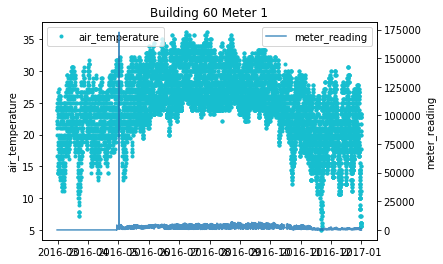

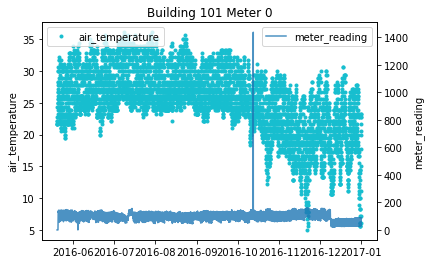

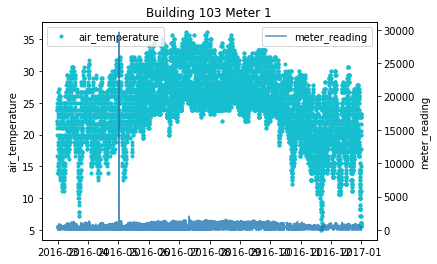

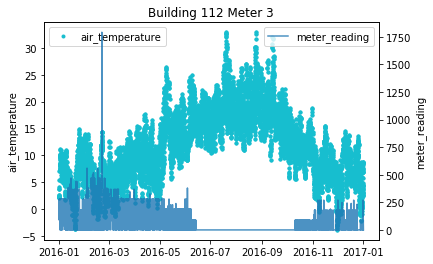

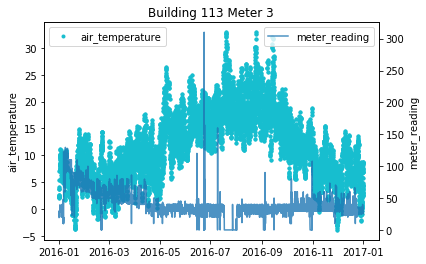

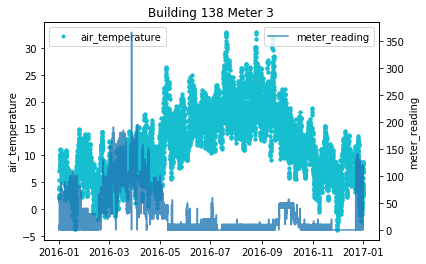

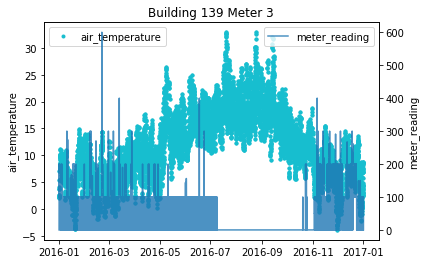

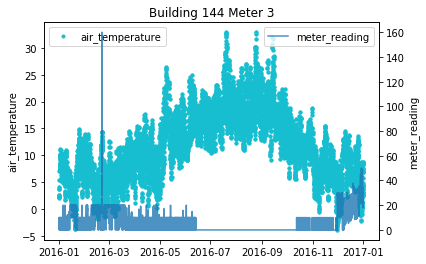

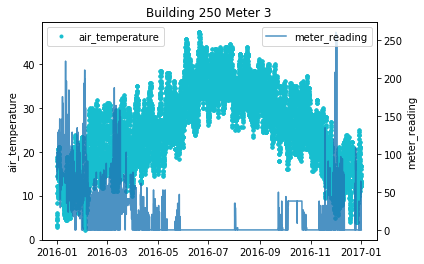

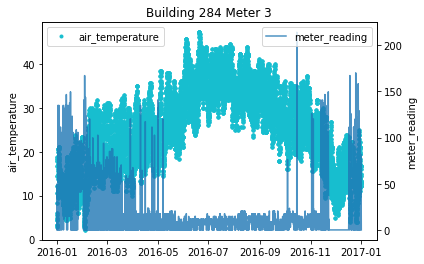

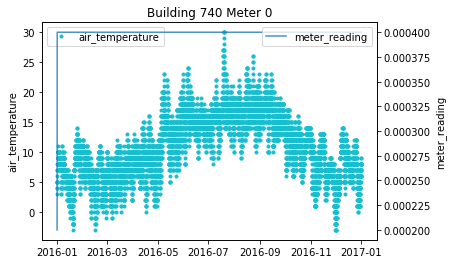

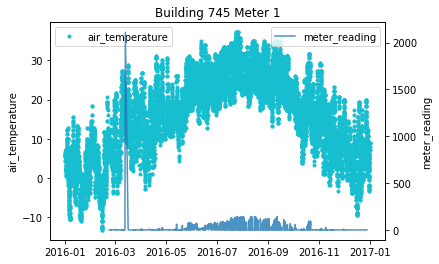

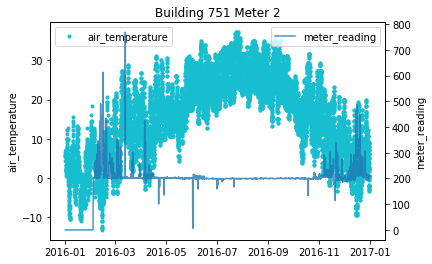

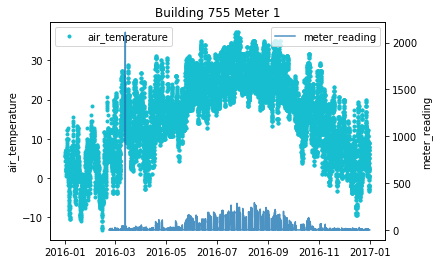

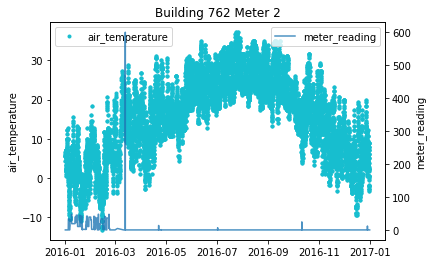

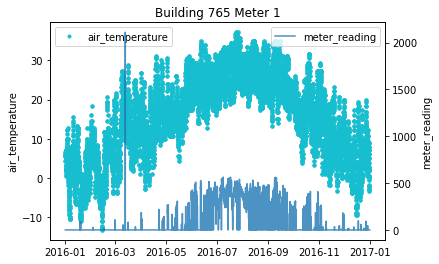

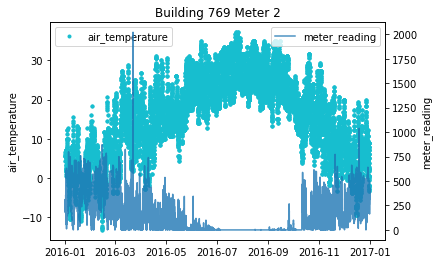

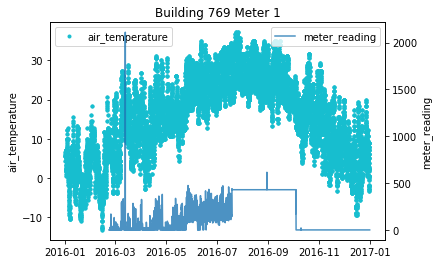

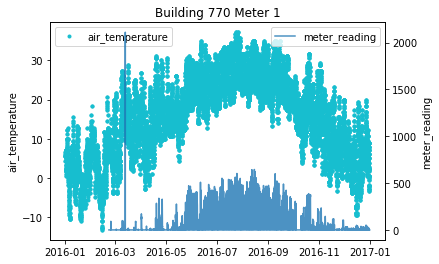

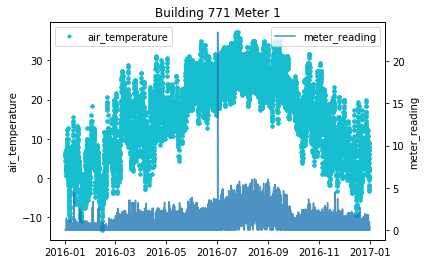

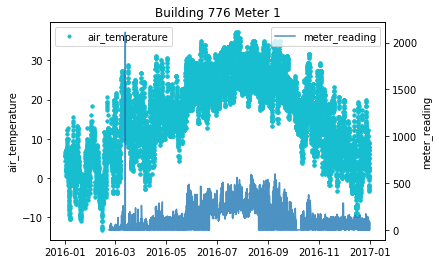

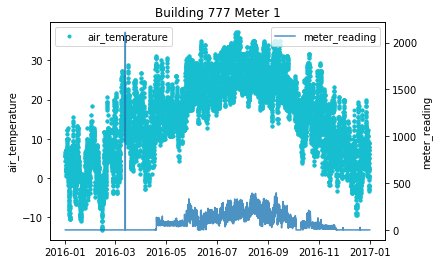

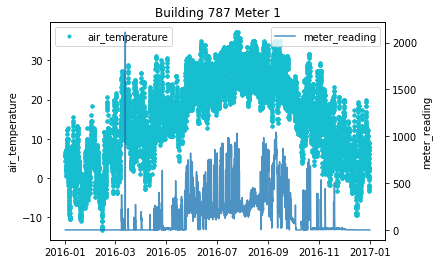

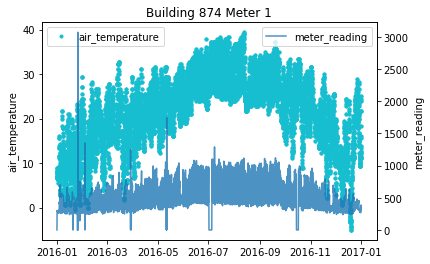

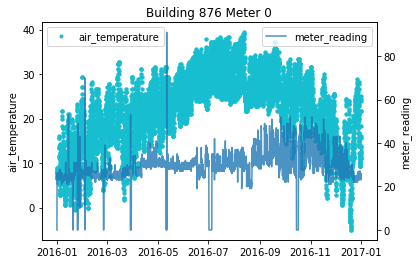

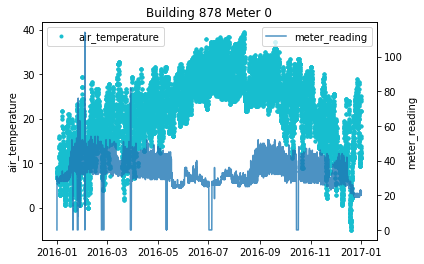

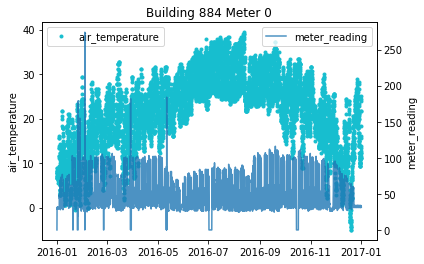

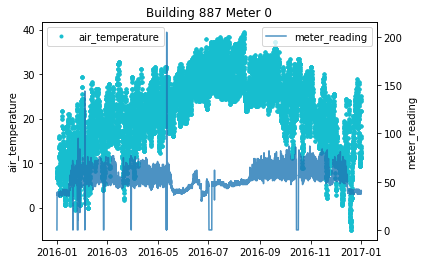

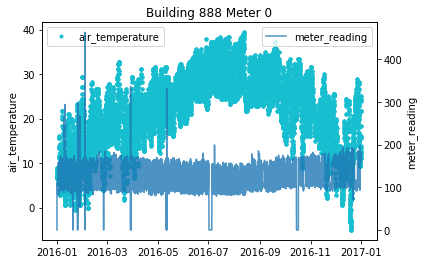

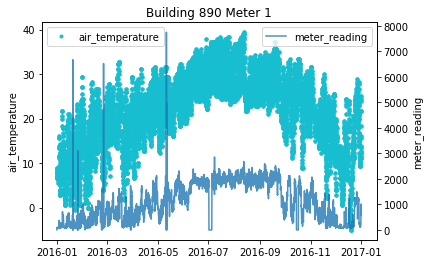

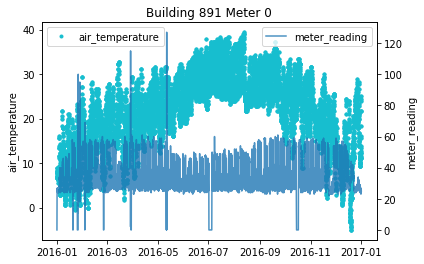

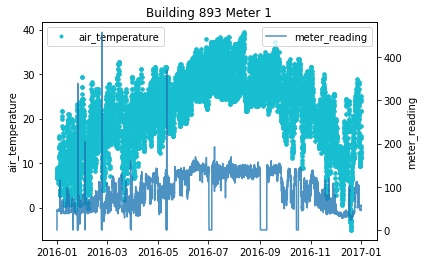

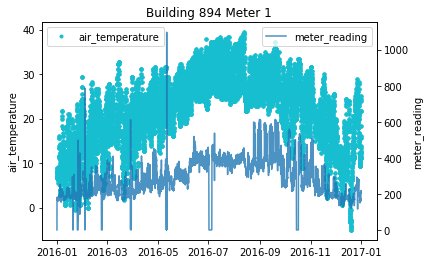

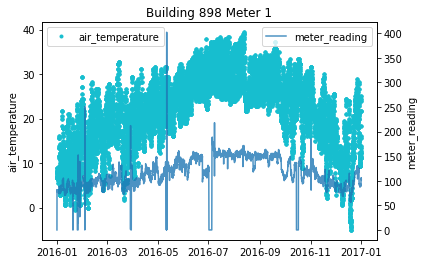

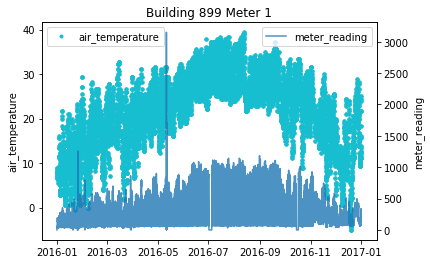

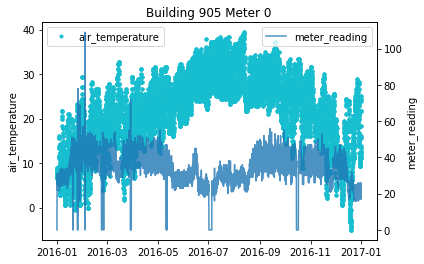

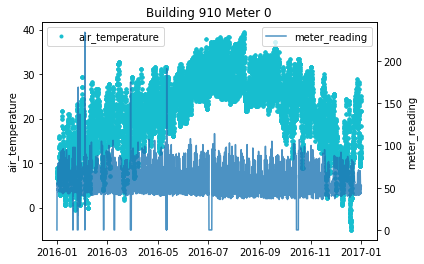

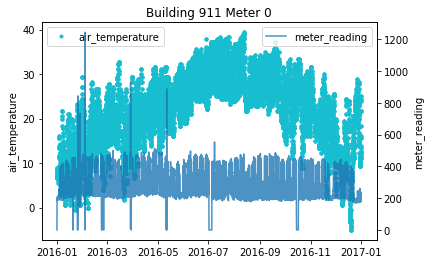

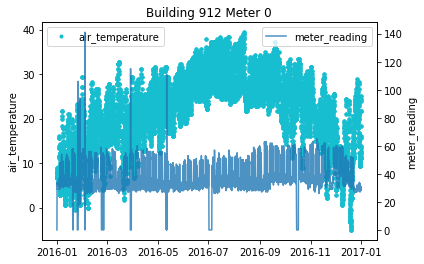

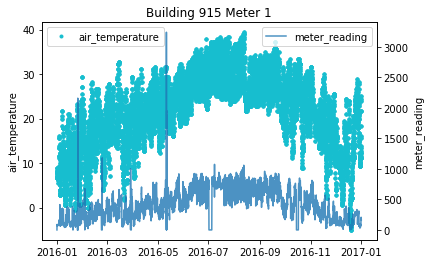

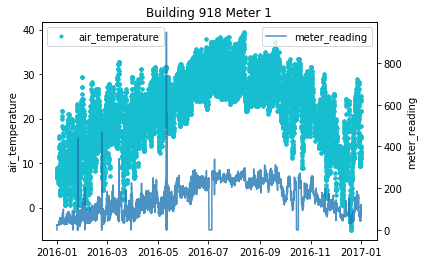

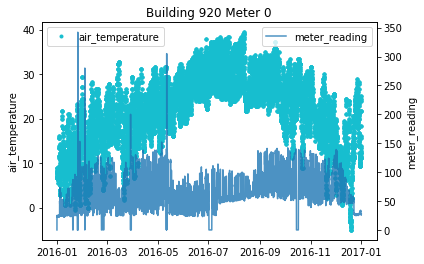

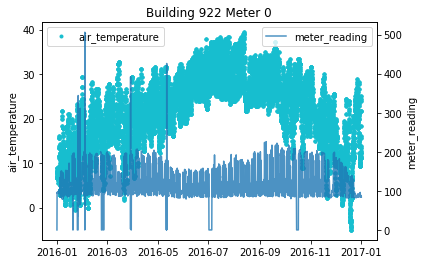

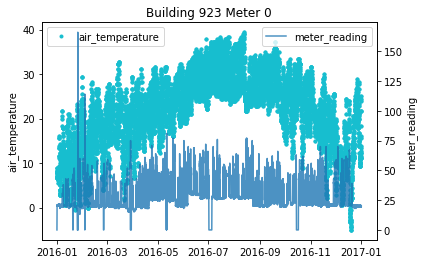

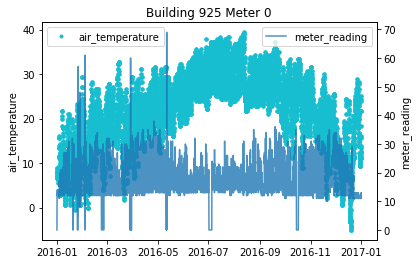

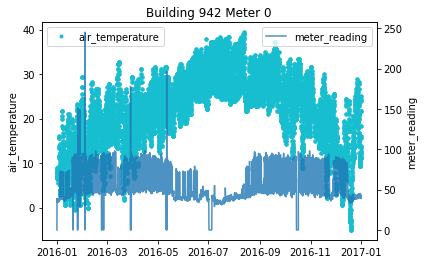

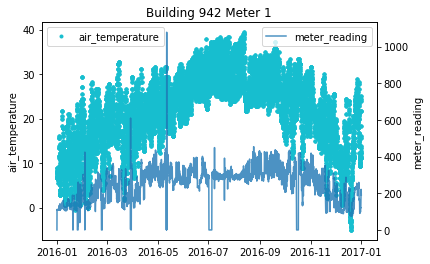

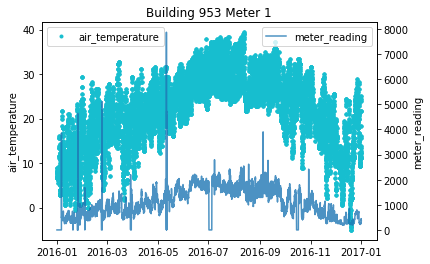

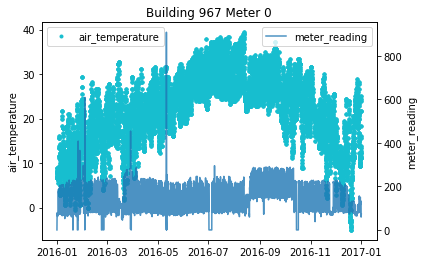

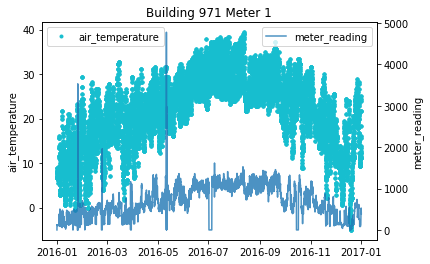

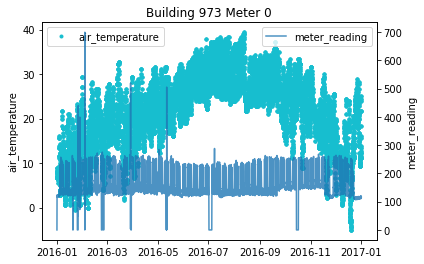

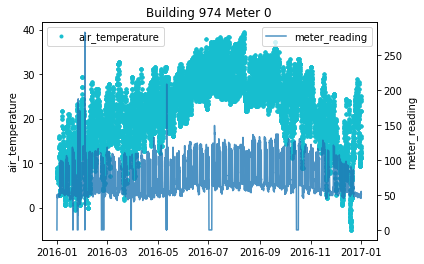

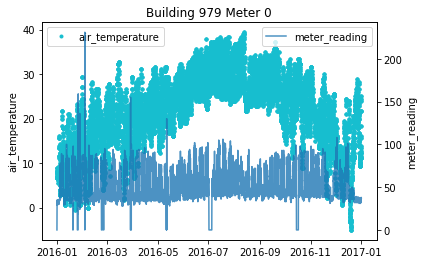

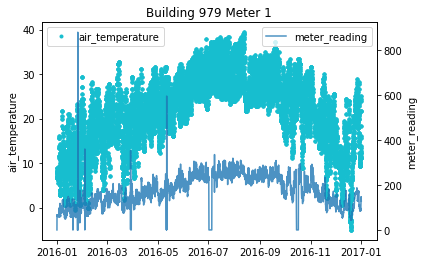

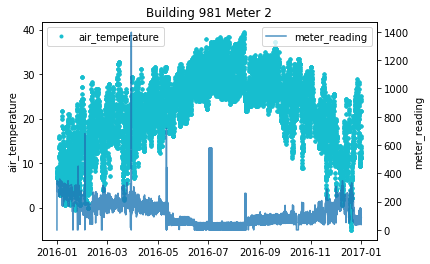

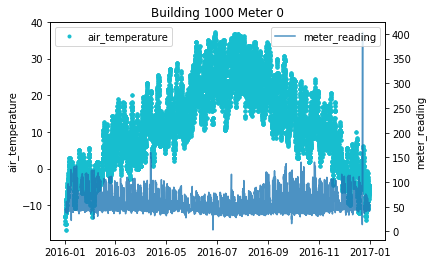

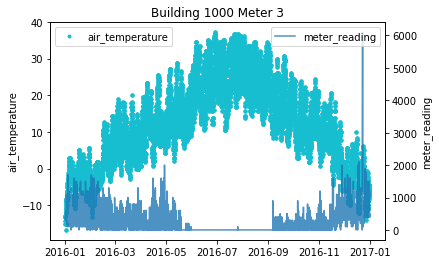

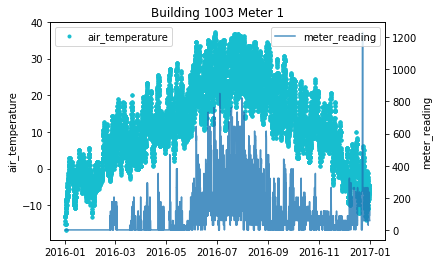

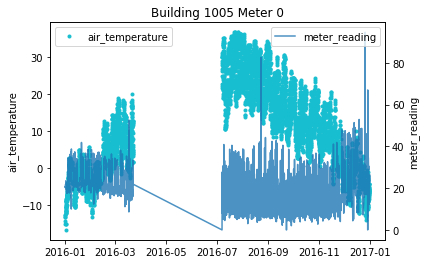

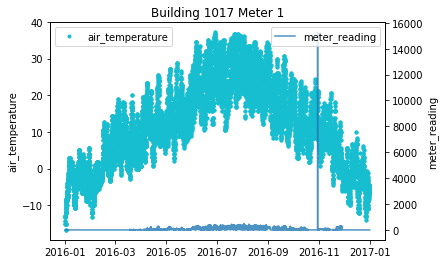

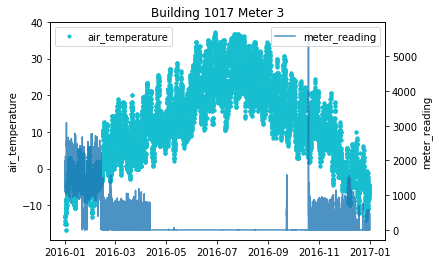

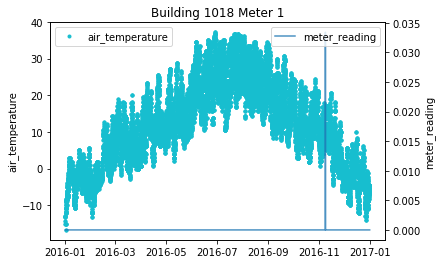

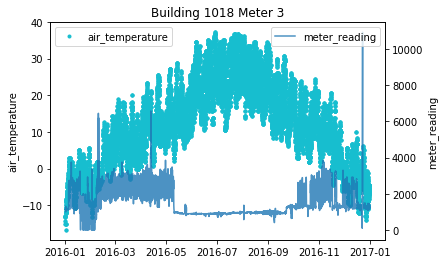

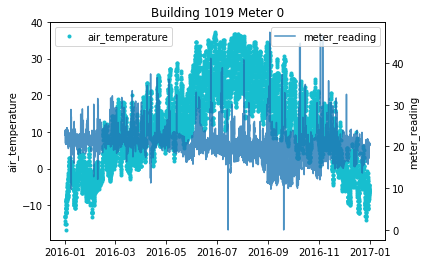

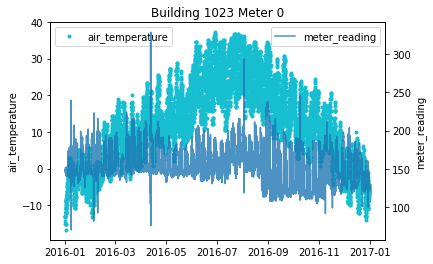

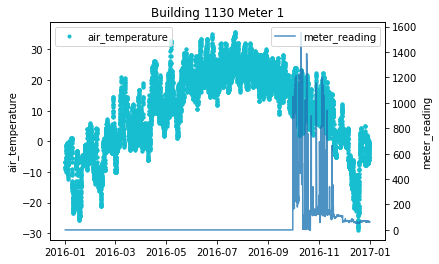

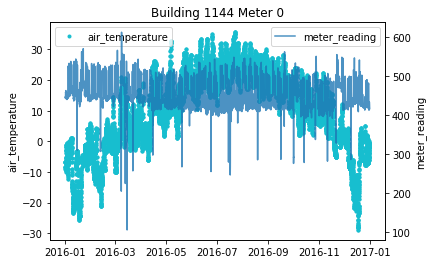

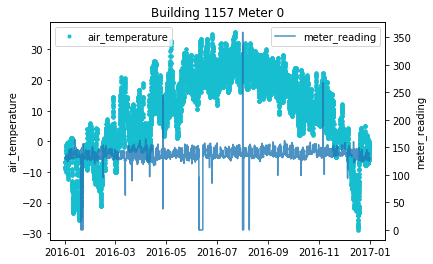

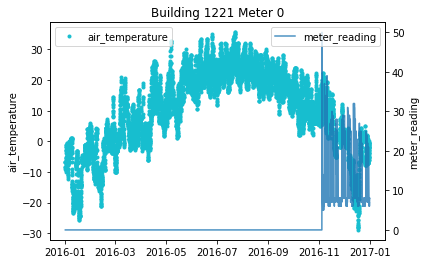

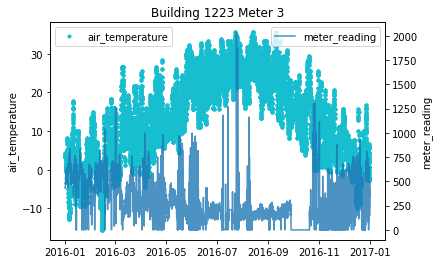

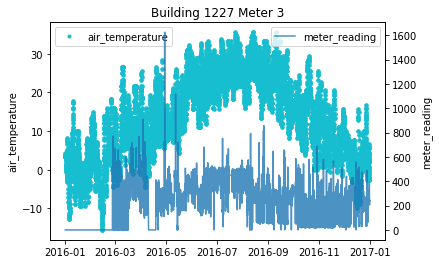

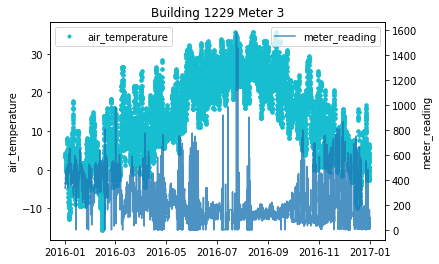

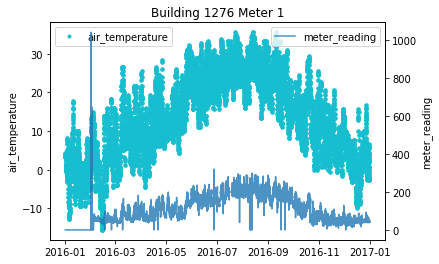

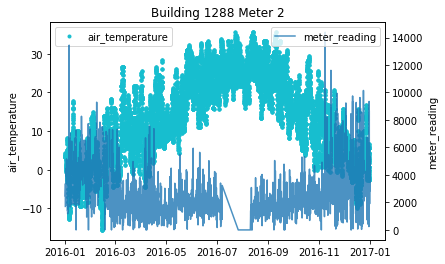

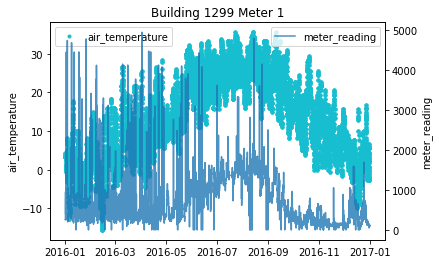

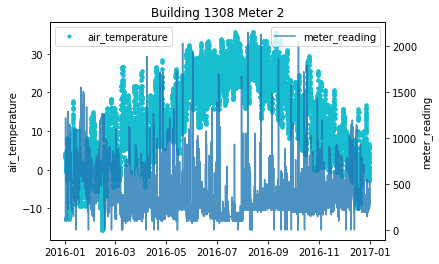

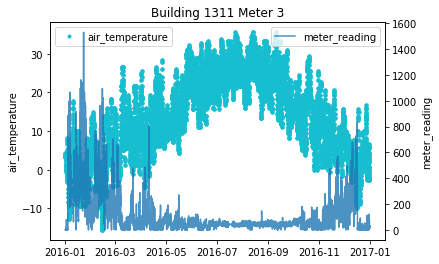

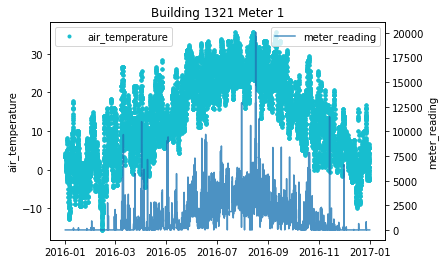

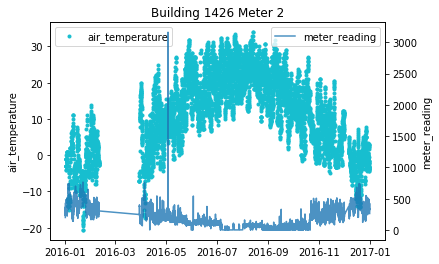

In [17]:
for i in range(0, 1449):
    #https://www.kaggle.com/hmendonca/starter-eda-and-feature-selection-ashrae3
    building_id = i # a building with all 4 meters
    meters = df[df['building_id'] == building_id].meter.unique()

    for meter in meters:

        idx = (df['building_id'] == building_id) & (df['meter'] == meter)
        df_idx = df[idx]
        outliers = detect_outlier(df_idx['meter_reading'])
        if len(outliers) == 1:
        
            fig, ax = plt.subplots()
            plt.title(f'Building {building_id} Meter {meter}')
            ax2 = ax.twinx()
            # plot meter_reading

            dates = matplotlib.dates.date2num(df.loc[idx, 'timestamp'])
            ax2.plot_date(dates, df.loc[idx, 'meter_reading'].clip(0), '-', label='meter_reading', alpha=0.8)
            # plot air_temperature
            dates = matplotlib.dates.date2num(df.loc[df['building_id'] == building_id, 'timestamp'])
            ax.plot_date(dates, df.loc[df['building_id'] == building_id, 'air_temperature'], '.', color='tab:cyan', label='air_temperature')
            ax.set_ylabel('air_temperature'); 
            ax2.set_ylabel('meter_reading')
            ax.legend(loc='upper left'); ax2.legend(loc='upper right')

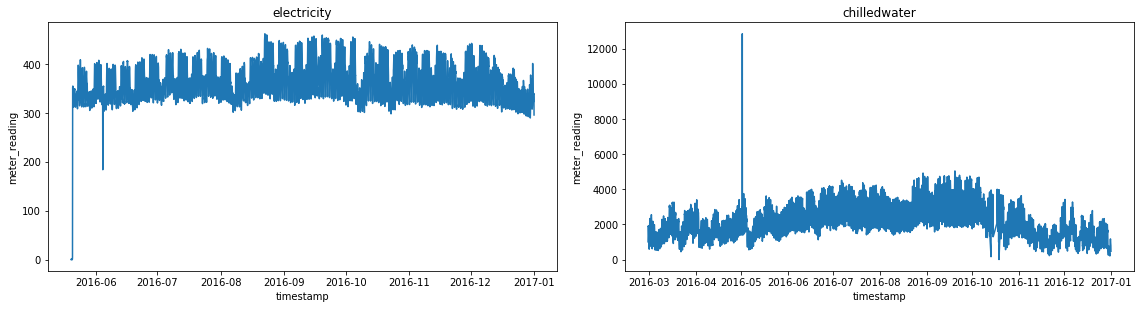

In [18]:
sitio = 0 # hay hasta 15 inclusive
dict_mter = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
meters = df[df['site_id'] == sitio].meter.nunique()

plt.figure(figsize=(16,8))
for meter in range(meters):
    plt.subplot(2, 2, meter + 1)
    ts=df[(df['meter'] == meter) & (df['site_id'] == sitio)].groupby(["timestamp"])["meter_reading"].mean()
    ts.astype('float')
    plt.title(dict_mter[meter])
    plt.xlabel('timestamp')
    plt.ylabel('meter_reading')
    plt.plot(ts);
plt.tight_layout()

MODELADO
----

In [19]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
feature_cols = ['log_square_feet', 'year_built', 'floor_count'] + [ # ++ floor_count
    'hour', 'month', 'dayofweek', 'weekofmonth'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed']  

'''
+ ['mes' + str(x) for x in np.arange(1, 12)]
+ ['building_mean', 'building_median',
                                       'building_min',
                                       'building_max',
                                       'building_std']
+ ['air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',
    'wind_direction_mean_lag3', 'wind_speed_mean_lag3'] 

+ ['air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72']
    '''


"\n+ ['mes' + str(x) for x in np.arange(1, 12)]\n+ ['building_mean', 'building_median',\n                                       'building_min',\n                                       'building_max',\n                                       'building_std']\n+ ['air_temperature_mean_lag3',\n    'air_temperature_max_lag3',\n    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',\n    'dew_temperature_mean_lag3',\n    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',\n    'wind_direction_mean_lag3', 'wind_speed_mean_lag3'] \n\n+ ['air_temperature_mean_lag72',\n    'air_temperature_max_lag72', 'air_temperature_min_lag72',\n    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',\n    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',\n    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',\n    'wind_speed_mean_lag72']\n    "

In [20]:
# IDEA: modelo por meter (electrico, steam, ...) 

In [21]:
target_col = 'meter_reading'

In [22]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2' # RMSE --> porque hemos aplicado previamente log1p 
    params = {'num_leaves': 32, # 31
              'objective': 'regression',
#           'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9, 
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              'lambda_l1': 0.01,
              'lambda_l2': 0.01
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 100 #20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params, train_set=d_train, num_boost_round=num_rounds, valid_sets=watchlist, verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [23]:
folds = 3
seed = 666
shuffle = False
group_folds_label = 'weekofmonth'
DO_FOLDS = True
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

In [24]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df[target_col].values

    del target_train_df
    return X_train, y_train

def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()
    
def cv_strategy(X_train, y_train, models0, kf,y_valid_pred_total, d_k_folds=True):

    if d_k_folds: # kFolds
        n_folds = 0
        for train_idx, valid_idx in kf.split(X_train, y_train, groups=X_train[group_folds_label]): #kf.split(...)
            print('Folds --> ', n_folds)
            n_folds += 1
            train_data = X_train.iloc[train_idx,:], y_train[train_idx]
            valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

            print('train', len(train_idx), 'valid', len(valid_idx))
        #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
            model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                                num_rounds=1500, lr=0.05, bf=0.8)
                  
            y_valid_pred_total[valid_idx] = y_pred_valid
            models0.append(model)
            gc.collect()
        
    else: # todo
        
        train_data = X_train, y_train
        valid_data = X_train.iloc[:2056,:], y_train[:2056]

        print('train', len(X_train), 'valid', len(valid_data))
    #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
        model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                            num_rounds=1500, lr=0.05, bf=0.8)
        
        models0.append(model)
        gc.collect()

    return models0

In [25]:
'''
%%time
modelos = []
for target_meter in np.arange(4):

    X_train, y_train = create_X_y(df, target_meter=target_meter)
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()
    print('target_meter', target_meter, X_train.shape)

    cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
    print('cat_features', cat_features)

    models0 = []
    
    # entrenar
    modelos.append(cv_strategy(X_train, y_train,
                               models0,
                               kf,
                               y_valid_pred_total,
                               d_k_folds=DO_FOLDS))
    
    print('RMSE:', np.sqrt(mean_squared_error( np.clip(y_train, 0, np.max(y_train)),
                                                   np.clip(y_valid_pred_total, 0,np.max(y_valid_pred_total) ))))
        
    plot_feature_importance(models0[0])

    del X_train, y_train
    gc.collect()
    '''

"\n%%time\nmodelos = []\nfor target_meter in np.arange(4):\n\n    X_train, y_train = create_X_y(df, target_meter=target_meter)\n    y_valid_pred_total = np.zeros(X_train.shape[0])\n    gc.collect()\n    print('target_meter', target_meter, X_train.shape)\n\n    cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]\n    print('cat_features', cat_features)\n\n    models0 = []\n    \n    # entrenar\n    modelos.append(cv_strategy(X_train, y_train,\n                               models0,\n                               kf,\n                               y_valid_pred_total,\n                               d_k_folds=DO_FOLDS))\n    \n    print('RMSE:', np.sqrt(mean_squared_error( np.clip(y_train, 0, np.max(y_train)),\n                                                   np.clip(y_valid_pred_total, 0,np.max(y_valid_pred_total) ))))\n        \n    plot_feature_importance(models0[0])\n\n    del X_train, y_train\n    gc.collect()\n    "

In [26]:
del df
gc.collect()

339853

**test**
--

In [27]:
'''
%%time
print('loading...')
df_test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/test.csv')
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
print('Calculando semana del mes...')
df_test['weekofmonth'] = np.uint8(df_test['timestamp'].apply(get_week_of_month))
print('Setting los dummies ...')
#set_dummies(df_test)

#weather_test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv')
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])

print('preprocessing weather...')
weather_test = timestamp_align(weather_test)
weather_test = weather_test.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test.groupby('site_id').apply(lambda group: group.isna().sum())

print('Adding lagg weather...')
#add_lag_feature(weather_test, window=3)
#add_lag_feature(weather_test, window=72)

print('reduce mem usage...')
reduce_mem_usage(weather_test)
reduce_mem_usage(df_test)

gc.collect()
'''

"\n%%time\nprint('loading...')\ndf_test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/test.csv')\ndf_test['timestamp'] = pd.to_datetime(df_test['timestamp'])\nprint('Calculando semana del mes...')\ndf_test['weekofmonth'] = np.uint8(df_test['timestamp'].apply(get_week_of_month))\nprint('Setting los dummies ...')\n#set_dummies(df_test)\n\n#weather_test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv')\nweather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])\n\nprint('preprocessing weather...')\nweather_test = timestamp_align(weather_test)\nweather_test = weather_test.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))\nweather_test.groupby('site_id').apply(lambda group: group.isna().sum())\n\nprint('Adding lagg weather...')\n#add_lag_feature(weather_test, window=3)\n#add_lag_feature(weather_test, window=72)\n\nprint('reduce mem usage...')\nreduce_mem_usage(weather_test)\nreduce_mem_usage(df_test)\n\ngc.collect()\n

In [28]:
'''print('preprocessing building...')
df_test['building_mean'] = df_test['building_id'].map(building_mean)
df_test['building_median'] = df_test['building_id'].map(building_median)
df_test['building_min'] = df_test['building_id'].map(building_min)
df_test['building_max'] = df_test['building_id'].map(building_max)
df_test['building_std'] = df_test['building_id'].map(building_std)

del building_mean, building_median, building_min, building_max, building_std
'''
gc.collect()

0

In [29]:
def create_X(test_df,building_meta_df,weather_test_df, ASHRAE3Preprocessor, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    target_test_df = ASHRAE3Preprocessor.transform(target_test_df)
    
    X_test = target_test_df[feature_cols + category_cols]
    
    del target_test_df
    gc.collect()
    
    return X_test

def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models) # prediccion con media de modelos
    return y_test_pred_total

In [30]:
%%time
resultados_tests = []
for target_meter in np.arange(4):
    
    X_test = create_X(df_test,
                      building_meta_df,weather_test, ASHRAE3Preprocessor,
                      target_meter=target_meter)
    print('target_meter', target_meter, X_test.shape)
    gc.collect()

    y_test2 = pred(X_test, modelos[target_meter])
    resultados_tests.append(y_test2.reshape(-1,1))
    sns.distplot(y_test2)

    del X_test
    gc.collect()

NameError: name 'df_test' is not defined

SUBMISION
----

In [31]:
%%time
sample_submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
sample_submission = reduce_mem_usage(sample_submission)
sample_submission.head()

Mem. usage decreased to 198.83 Mb (68.7% reduction)
CPU times: user 7.41 s, sys: 2.1 s, total: 9.51 s
Wall time: 8.57 s


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [32]:
%%time
sample_submission.loc[df_test['meter'] == 0, 'meter_reading'] = np.expm1(resultados_tests[0])
sample_submission.loc[df_test['meter'] == 1, 'meter_reading'] = np.expm1(resultados_tests[1])
sample_submission.loc[df_test['meter'] == 2, 'meter_reading'] = np.expm1(resultados_tests[2])
sample_submission.loc[df_test['meter'] == 3, 'meter_reading'] = np.expm1(resultados_tests[3])
sample_submission['meter_reading'] = sample_submission['meter_reading'].clip(lower=0) # valor minimo, por si hay negativos

IndexError: list index out of range

In [33]:
sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')
sample_submission.head()

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
